# Project: Insight From Failed Orders

## Background Information
This data project has been used as a take-home assignment in the recruitment process for the data science positions at Gett.

Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

## Assignments
1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

4. Plot the distribution of average ETA by hours. How can this plot be explained?
BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

### Import libraries and load data

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import folium
from shapely.geometry import Polygon
import h3
import branca

sns.set_theme(style="white", context="notebook")

In [2]:
offers = pd.read_csv('data_offers.csv')
orders = pd.read_csv('data_orders.csv')

print(f'shape of offers: {offers.shape}')
print(f'shape of orders: {orders.shape}')

shape of offers: (334363, 2)
shape of orders: (10716, 8)


In [3]:
offers.head(5)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [4]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


## Data Descriptions
We have two data sets: **data_orders** and **data_offers**, both being stored in a CSV format. The **data_orders** data set contains the following columns:

- `order_datetime` - time of the order
- `origin_longitude` - longitude of the order
- `origin_latitude` - latitude of the order
- `m_order_eta` - time before order arrival
- `order_gk` - order number
- `order_status_key` - status, an enumeration consisting of the following mapping:
    + 4 - cancelled by client,
    + 9 - cancelled by system, i.e., a reject
- `is_driver_assigned_key` - whether a driver has been assigned
- `cancellation_time_in_seconds` - how many seconds passed before cancellation


The **data_offers** data set is a simple map with 2 columns:

- `order_gk` - order number, associated with the same column from the orders data set
- `offer_id` - ID of an offer

## Data Explorations

Is the **orders** table only contains cancelled order?

In [5]:
orders['order_status_key'].unique()

array([4, 9])

--> Yes it only contains `order_status_key` of 4 and 9 which means canceled by client or by system respectively.

What is the data type of the `order_datetime` column?

In [6]:
orders.dtypes

order_datetime                    object
origin_longitude                 float64
origin_latitude                  float64
m_order_eta                      float64
order_gk                           int64
order_status_key                   int64
is_driver_assigned_key             int64
cancellations_time_in_seconds    float64
dtype: object

--> It is in object type, might have to turn it into datetime.time type.

Is `order_gk` unique (primary key)?

In [7]:
orders['order_gk'].nunique() == orders.shape[0]

True

### Question 1

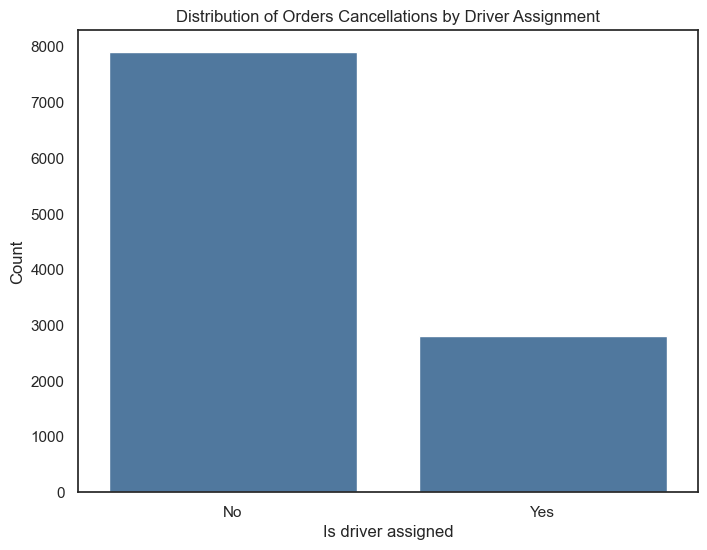

In [8]:
plt.figure(figsize=(8,6))
ax = sns.countplot(data=orders, x='is_driver_assigned_key', color='#4379AB')
plt.title('Distribution of Orders Cancellations by Driver Assignment')
plt.xlabel('Is driver assigned')
plt.ylabel('Count')
ax.set_xticks([0, 1])              
ax.set_xticklabels(["No", "Yes"]);

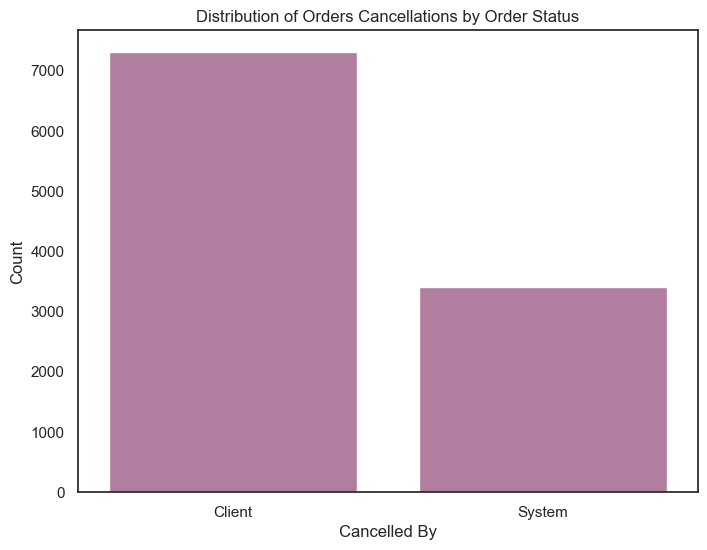

In [9]:
plt.figure(figsize=(8,6))
ax = sns.countplot(data=orders, x='order_status_key', color='#B976A3')
plt.title('Distribution of Orders Cancellations by Order Status')
plt.xlabel('Cancelled By')
plt.ylabel('Count')
ax.set_xticks([0, 1])              
ax.set_xticklabels(["Client", "System"]);

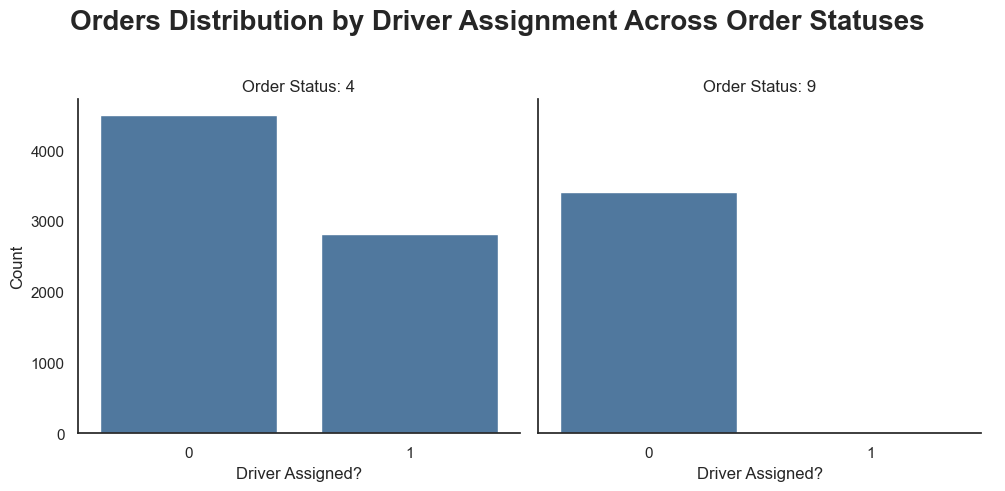

In [10]:
g = sns.catplot(
    data=orders,
    x="is_driver_assigned_key",
    color='#4379AB',
    kind="count",
    col="order_status_key",
    height=5, aspect=1
)

g.set_titles("Order Status: {col_name}")
g.set_axis_labels("Driver Assigned?", "Count")


g.figure.suptitle("Orders Distribution by Driver Assignment Across Order Statuses", fontsize=20, weight='bold')

# Adjust top margin to fit the title
g.figure.subplots_adjust(top=0.8)

**Observation**:
- Most orders were cancelled before the driver was assigned.
- For orders that cancelled by client, more than 4000 orders which did not have the driver assigned and almost 3000 orders which assigned drivers.
- For orders that cancelled by the system, all of orders weren't assigned drivers and made up to more than 3000 orders.


### Question 2

We can create a new column `hour` to analyze the distribution of failed orders by hour.

In [11]:
orders['hour'] = orders['order_datetime'].apply(lambda x: x.split(':')[0])

orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21


In [12]:
orders['hour'].unique()

array(['18', '20', '12', '13', '21', '07', '08', '06', '15', '16', '00',
       '14', '17', '22', '01', '19', '03', '23', '09', '02', '11', '04',
       '10', '05'], dtype=object)

Change to int type for easier sorting

In [13]:
orders['hour'] = orders['hour'].astype('int')

In [14]:
np.sort(orders['hour'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

C:\Users\truon\AppData\Local\Temp\ipykernel_46448\1075460274.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(data=orders, x='hour', hue='order_status_key', palette=my_pallete)


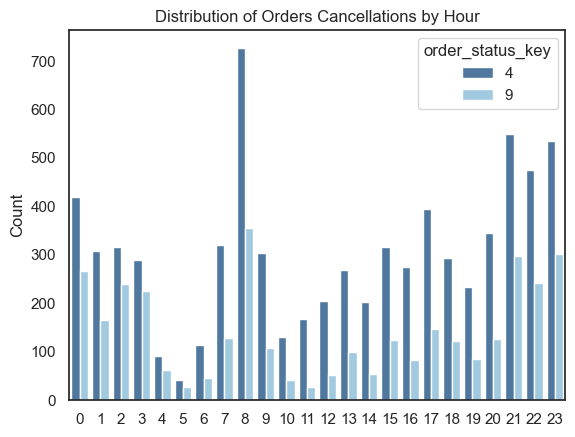

In [15]:
my_pallete = ['#4379AB', "#96CCEB", '#7B706E']


sns.countplot(data=orders, x='hour', hue='order_status_key', palette=my_pallete)
plt.title('Distribution of Orders Cancellations by Hour')
plt.xlabel('')
plt.ylabel('Count');

**Observations**:
- Regardless of the order status the distribution of order cancellation follow the same pattern.
- With the peak in order cancellation at 8am, canceled orders droped significantly right after then slowly increase as the hour goes by.
- Reasons for the peak could be that is the time the demand is in its highest, when people need to get to work, school etc. Same reason could be explained for the increase at night time when people need rides to get home from dinner. As the demand gets high, there could be not enough drivers assigned to customers (Long waiting time) causes cancellation.

### Question 3

Average time to cancellation

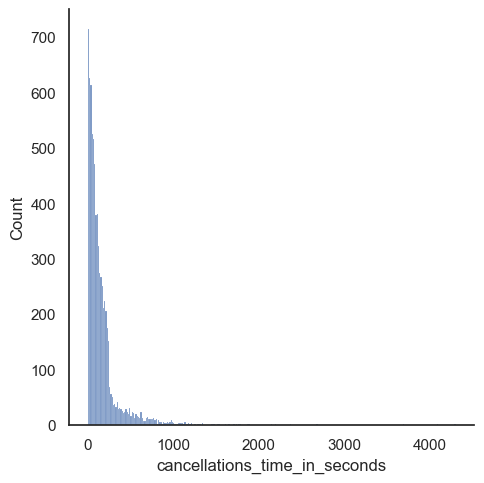

In [16]:
sns.displot(data=orders, x='cancellations_time_in_seconds');

The distribution of cancellations time is right skewed due to the present of outliers.

In [17]:
orders['cancellations_time_in_seconds'].describe()

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

In [18]:
orders['cancellations_time_in_seconds'].quantile(.90)

np.float64(339.0)

We will define a threshold of 339 seconds ~ 5 minutes (90th quantile) as maximum wait time and trim the values that fall outside of this range. The extreme values could be due to various reasons, e.g system errors, accidents etc.

In [19]:
threshhold = orders['cancellations_time_in_seconds'].quantile(.90)

orders_trimmed = orders[orders['cancellations_time_in_seconds'] <= threshhold]

In [20]:
orders.shape[0] - orders_trimmed.shape[0]

4138

There are total of 4138 rows removed. Those includes NA values and outliers.

In [21]:
orders_trimmed

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13
9,06:33:52,-0.976216,51.433202,NaN,3000582765616,4,0,78.0,6
...,...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0,13
10712,13:13:55,-0.975372,51.457846,NaN,3000599186962,4,0,4.0,13
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,13
10714,13:16:28,-0.975372,51.457846,NaN,3000599187024,4,0,6.0,13


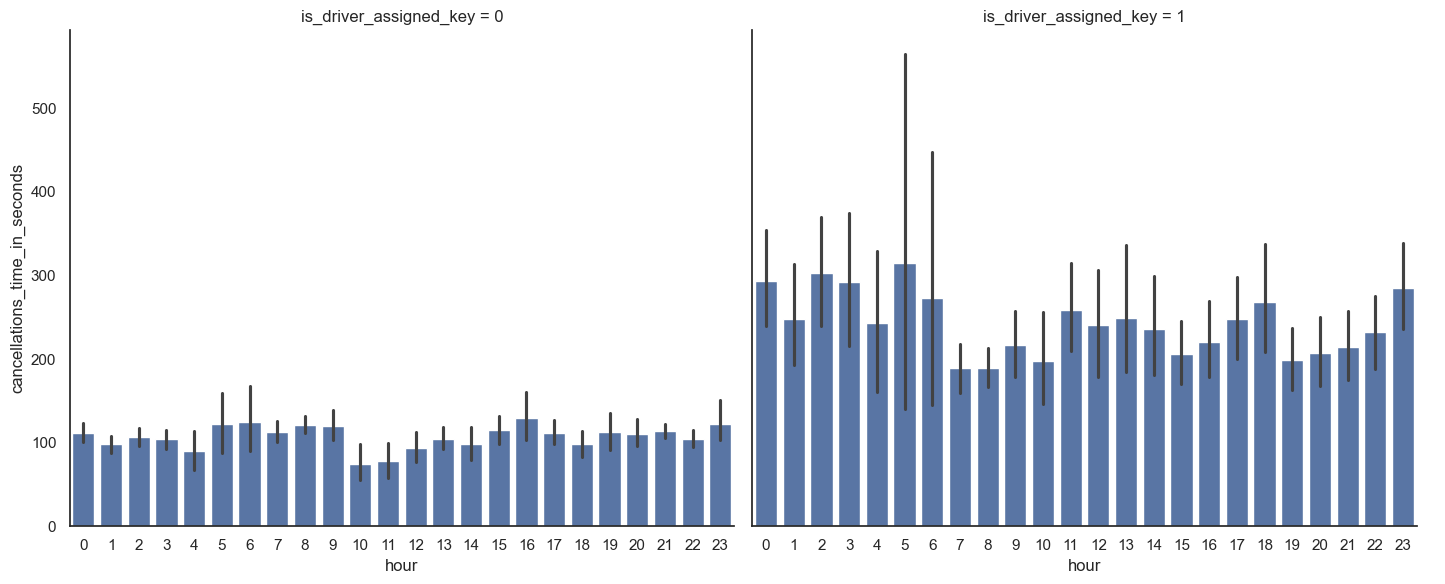

In [22]:
sns.catplot(
    data=orders,
    x='hour', y='cancellations_time_in_seconds',
    col='is_driver_assigned_key',
    kind='bar',
    estimator='mean',
    height=6, aspect=1.2
);

Without drivers, the average cancellation time is much lower, all under 150s. This means that on average, customers only need to wait under 150s to have their driver assigned. The distribution of the average cancellation time when driver is not assigned do not differ too much and more or less stable across hour of the day.

With drivers assigned, the average cancellation time is higher as we would expect and there seem to be two time range that appear to have the average cancellation time lower from the rest. They are from 7am to 10am and 7pm to 10pm. These could also be explained by the high demand in customers who need a ride from those time range (going to work, going out for dinner etc.). Hence there are more supply that leads to more options or alternatives for them to choose from. One could cancel if it's taking a bit too long and book a faster alternative (ride from friends/buses etc.) that can save their time. Whereas from other time there are less options for customers to choose from, they'd rather wait a bit longer for their driver to arrive.

### Question 4

In [23]:
orders['m_order_eta'].describe()

count    2814.000000
mean      441.415423
std       288.006379
min        60.000000
25%       233.000000
50%       368.500000
75%       653.000000
max      1559.000000
Name: m_order_eta, dtype: float64

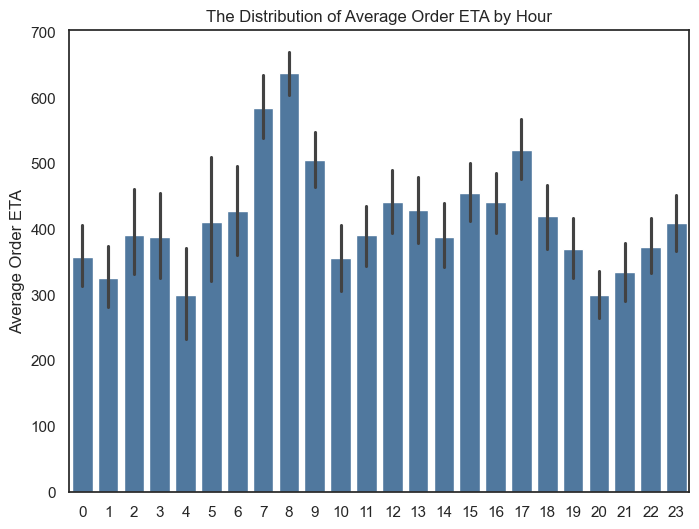

In [24]:
plt.figure(figsize=(8,6))
sns.barplot(data=orders, x='hour', y='m_order_eta', color='#4379AB', estimator='mean')
plt.title('The Distribution of Average Order ETA by Hour')
plt.xlabel('')
plt.ylabel('Average Order ETA');

As we would expect, the peak hours are in the morning 7am to 9am, and in the evening 3pm to 6pm. Those are time when people either going to work or going home after work leading to spike in demand and hence longer ETA.

### Question 5

In [25]:
orders.head(1)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18


In [26]:
orders['h3_8'] = orders.apply(lambda x: h3.latlng_to_cell(x['origin_latitude'], x['origin_longitude'], 8), axis=1)

In [27]:
len(orders['h3_8'].unique())

144

There are 144 unique hex cell.

In [28]:
hex_summary = orders.groupby('h3_8').size().reset_index(name='fail_orders')

hex_summary = hex_summary.sort_values('fail_orders', ascending=False)

hex_summary.head(10)

,h3_8,fail_orders
97,88195d2b1dfffff,1497
96,88195d2b1bfffff,870
93,88195d2b15fffff,774
91,88195d2b11fffff,707
95,88195d2b19fffff,667
20,88195d284dfffff,653
63,88195d2a27fffff,414
89,88195d2b0bfffff,372
62,88195d2a25fffff,362
92,88195d2b13fffff,346


In [29]:
hex_summary['cum_pct'] = hex_summary['fail_orders'].cumsum() / hex_summary['fail_orders'].sum()

hex_summary.head(10)

,h3_8,fail_orders,cum_pct
97,88195d2b1dfffff,1497,0.139698
96,88195d2b1bfffff,870,0.220885
93,88195d2b15fffff,774,0.293113
91,88195d2b11fffff,707,0.359089
95,88195d2b19fffff,667,0.421333
20,88195d284dfffff,653,0.482270
63,88195d2a27fffff,414,0.520903
89,88195d2b0bfffff,372,0.555618
62,88195d2a25fffff,362,0.589399
92,88195d2b13fffff,346,0.621687


Now we have for each hex the number of fail_oders and the cummulative percentage of the fail orders. Now we need to find out how many hexes that make up to 80% of the failed orders.

In [30]:
hex_80 = hex_summary[hex_summary['cum_pct'] <= 0.8]

hex_80.shape[0]

23

From 144 (100%) now down to 23 hexes (made up to 80% of failed orders).

In [31]:
center_lat, center_lng = orders['origin_latitude'].mean(), orders['origin_longitude'].mean()

In [33]:
m = folium.Map(location=[center_lat, center_lng], zoom_start=11, tiles="cartodbpositron")

In [46]:
def h3_to_polygon(hex_id):
    """Convert H3 hex to lat/lng polygon for folium"""
    boundary = h3.cell_to_boundary(hex_id)
    return [(lat, lng) for lat, lng in boundary]

In [47]:
a_hex = hex_80['h3_8'].iloc[0]

h3_to_polygon(a_hex)

[(51.46233424112638, -0.9674195894273443),
 (51.46108611918585, -0.974152249229657),
 (51.45658471409391, -0.9753174349705687),
 (51.45333169192243, -0.9697507654750084),
 (51.45457984273564, -0.9630191652468647),
 (51.45908098683117, -0.9618531750496474)]

In [52]:
# Create a colormap
max_fail = hex_80["fail_orders"].max()
min_fail = hex_80["fail_orders"].min()
colormap = branca.colormap.LinearColormap(
    colors=["#ffffcc", "#ff4444"],  # light yellow -> dark red
    vmin=min_fail, vmax=max_fail,
    caption="Number of Failed Orders"
)


# Add hex polygons to map
for _, row in hex_80.iterrows():
    polygon = h3_to_polygon(row["h3_8"])
    count = row["fail_orders"]
    folium.Polygon(
        locations=polygon,
        color="black",
        weight=0.5,
        fill=True,
        fill_opacity=0.6,
        fill_color=colormap(count),
        popup=f"Fails: {count}"
    ).add_to(m)
    
# Add colormap legend
m.add_child(colormap)

# Save map
m.save("fail_orders_hexmap.html")
m